In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import re
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from time import time
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint

# Load and prepare documents

In [2]:
df = pd.read_pickle("../data/cleaned_df")

In [3]:
df.head()

,question,cleaned,length,wc
0,Are you there?,are you there,13,3
1,Firstname:,firstname,9,1
2,I get irritated easily.,i get irritated easily,22,4
3,Comments,comments,8,1
4,Let's do a survey about exercising?,lets do a survey about exercising,33,6


In [4]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
# words from the wordcloud
stop_words.extend(['thank', 'please', 'whats', 'thanks', 'email', 'would', 'us', 'will', 'address', 
                   'question', 'questions', 'many', 'must', 'could', 'should'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARosa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def stemming(docs):
    porter_stemmer=nltk.PorterStemmer()
    return [[porter_stemmer.stem(word) for word in doc] for doc in docs]

# simple_preprocess: it lowercases, tokenizes, de-accents (optional) with deacc
def extract_words(questions):
    for q in questions:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(q), deacc=True))
        
def remove_stopwords(docs):
    # docs is a list of document. A document being a list of words
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in docs]
                

In [6]:
data = df.cleaned.values.tolist()
data[:10]

['are you there',
 'firstname',
 'i get irritated easily',
 'comments',
 'lets do a survey about exercising',
 'do you like our design',
 'thank you you are part of us now we will contact you with surprises soon',
 'have you ever paid for a service like this before',
 'what type of services are you interested in',
 'would you recommend indivirtual to other clients']

In [7]:
corpus = list(extract_words(data))
corpus[:10]

[['are', 'you', 'there'],
 ['firstname'],
 ['get', 'irritated', 'easily'],
 ['comments'],
 ['lets', 'do', 'survey', 'about', 'exercising'],
 ['do', 'you', 'like', 'our', 'design'],
 ['thank',
  'you',
  'you',
  'are',
  'part',
  'of',
  'us',
  'now',
  'we',
  'will',
  'contact',
  'you',
  'with',
  'surprises',
  'soon'],
 ['have', 'you', 'ever', 'paid', 'for', 'service', 'like', 'this', 'before'],
 ['what', 'type', 'of', 'services', 'are', 'you', 'interested', 'in'],
 ['would', 'you', 'recommend', 'indivirtual', 'to', 'other', 'clients']]

In [8]:
corpus_sw = remove_stopwords(corpus)
len(corpus_sw)

4306

In [9]:
corpus_sw[:10]

[[],
 ['firstname'],
 ['get', 'irritated', 'easily'],
 ['comments'],
 ['lets', 'survey', 'exercising'],
 ['like', 'design'],
 ['part', 'contact', 'surprises', 'soon'],
 ['ever', 'paid', 'service', 'like'],
 ['type', 'services', 'interested'],
 ['recommend', 'indivirtual', 'clients']]

We might have now some empty lists. Need to remove them.

In [10]:
def remove_empty_list(docs):
    return [doc for doc in docs if len(doc)>0]   

In [11]:
final_corpus = remove_empty_list(corpus_sw)

In [12]:
final_corpus_stem = stemming(final_corpus)

In [13]:
final_corpus_stem[:10]

[['firstnam'],
 ['get', 'irrit', 'easili'],
 ['comment'],
 ['let', 'survey', 'exercis'],
 ['like', 'design'],
 ['part', 'contact', 'surpris', 'soon'],
 ['ever', 'paid', 'servic', 'like'],
 ['type', 'servic', 'interest'],
 ['recommend', 'indivirtu', 'client'],
 ['select', 'bunch', 'stuff']]

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(final_corpus_stem)

# Convert document (a list of words) into the bag-of-words
# Each word is assumed to be a tokenized and normalized ( (either unicode or utf8-encoded).)
corpus = [id2word.doc2bow(doc) for doc in final_corpus_stem]

In [15]:
corpus[:10]

[[(0, 1)],
 [(1, 1), (2, 1), (3, 1)],
 [(4, 1)],
 [(5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(9, 1), (14, 1), (15, 1), (16, 1)],
 [(16, 1), (17, 1), (18, 1)],
 [(19, 1), (20, 1), (21, 1)],
 [(22, 1), (23, 1), (24, 1)]]

# LDA Algorithm
https://highdemandskills.com/topic-modeling-intuitive/

## LDA Assumptions

* The semantic content of a document is composed by combining one or more terms from one or more topics.

* Certain terms are ambiguous, belonging to more than one topic, with different probability. (For example, the term training can apply to both dogs and cats, but are more likely to refer to dogs, which are used as work animals or participate in obedience or skill competitions.) However, in a document, the accompanying presence of specific neighboring terms (which belong to only one topic) will disambiguate their usage.

* Most documents will contain only a relatively small number of topics. In the collection, e.g., individual topics will occur with differing frequencies. That is, they have a probability distribution, so that a given document is more likely to contain some topics than others.

* Within a topic, certain terms will be used much more frequently than others. In other words, the terms within a topic will also have their own probability distribution.

## LDA Parameters

   **Alpha parameter**: is Dirichlet prior concentration parameter that represents document-topic density — it relates to the distribution of topics in documents.

   **Eta parameter** (beta in some doc): represents topic-word density — it relates to the distribution of words in topics.

Lower values will lead to distributions that are more dispersed. We can let the model learn alpha and beta values for us, allowing to learn asymmetric vectors.

It would be nice to use *ldamulticore* to parallelize and speed up model training but it does not support the auto parameters.
*NotImplementedError: auto-tuning alpha not implemented in multicore LDA; use plain LdaModel.*

# LDA 5 Topics

In [16]:
# let´s start with 5 topics
num_topics = 5

# Build LDA model, learn asymmetric alpha from data
lda_model5 = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       alpha='auto',
                                       eta='auto',
                                       num_topics=num_topics,
                                       random_state=42)

# Print the key words for the 5 topics
pprint(lda_model5.print_topics())

[(0,
  '0.165*"requir" + 0.148*"dietari" + 0.042*"name" + 0.013*"time" + '
  '0.010*"number" + 0.010*"much" + 0.008*"comment" + 0.008*"enter" + '
  '0.007*"use" + 0.007*"compani"'),
 (1,
  '0.127*"like" + 0.076*"softwar" + 0.076*"page" + 0.075*"appear" + '
  '0.072*"use" + 0.062*"item" + 0.055*"want" + 0.053*"usual" + '
  '0.046*"notstrong" + 0.038*"often"'),
 (2,
  '0.157*"say" + 0.154*"littl" + 0.011*"like" + 0.010*"project" + '
  '0.008*"provid" + 0.008*"interest" + 0.007*"help" + 0.007*"share" + '
  '0.006*"anyth" + 0.006*"current"'),
 (3,
  '0.012*"like" + 0.010*"tell" + 0.010*"take" + 0.010*"type" + '
  '0.009*"feedback" + 0.009*"answer" + 0.008*"describ" + 0.008*"want" + '
  '0.008*"best" + 0.008*"survey"'),
 (4,
  '0.080*"think" + 0.078*"click" + 0.078*"strongif" + 0.078*"success" + '
  '0.078*"handl" + 0.078*"twitter" + 0.071*"home" + 0.045*"like" + '
  '0.040*"often" + 0.024*"notstrong"')]


In [17]:
lda_model5.alpha

array([0.16284077, 0.17981362, 0.15835455, 0.13282692, 0.20223586],
      dtype=float32)

# LDA 3 Topics

In [53]:
num_topics = 3
lda_model3 = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       alpha='auto',
                                       eta='auto',
                                       num_topics=num_topics,
                                       random_state=42)


In [54]:
# Print the key words for the 3 topics
pprint(lda_model3.print_topics())

[(0,
  '0.083*"littl" + 0.083*"handl" + 0.083*"twitter" + 0.074*"strongif" + '
  '0.073*"say" + 0.021*"name" + 0.014*"notstrong" + 0.013*"use" + 0.008*"time" '
  '+ 0.007*"home"'),
 (1,
  '0.114*"like" + 0.052*"often" + 0.051*"item" + 0.050*"page" + 0.050*"appear" '
  '+ 0.050*"usual" + 0.050*"click" + 0.050*"use" + 0.050*"softwar" + '
  '0.049*"want"'),
 (2,
  '0.097*"think" + 0.089*"success" + 0.086*"requir" + 0.080*"dietari" + '
  '0.012*"say" + 0.009*"like" + 0.007*"want" + 0.007*"project" + 0.006*"one" + '
  '0.006*"provid"')]


In [55]:
lda_model3.alpha

array([0.37181285, 0.35028467, 0.3230608 ], dtype=float32)

# LDA 7 Topics

In [56]:
num_topics = 7
lda_model7 = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       alpha='auto',
                                       eta='auto',
                                       num_topics=num_topics,
                                       random_state=42)

In [57]:
# Print the key words for the 7 topics
pprint(lda_model7.print_topics())

[(0,
  '0.209*"home" + 0.064*"name" + 0.015*"number" + 0.014*"time" + '
  '0.013*"comment" + 0.012*"use" + 0.010*"first" + 0.009*"usual" + '
  '0.009*"phone" + 0.008*"rate"'),
 (1,
  '0.146*"like" + 0.085*"say" + 0.085*"softwar" + 0.080*"appear" + '
  '0.077*"usual" + 0.076*"page" + 0.074*"use" + 0.073*"want" + '
  '0.042*"notstrong" + 0.018*"home"'),
 (2,
  '0.019*"provid" + 0.015*"share" + 0.014*"like" + 0.012*"interest" + '
  '0.011*"help" + 0.010*"contact" + 0.010*"current" + 0.009*"websit" + '
  '0.008*"locat" + 0.008*"team"'),
 (3,
  '0.166*"item" + 0.165*"handl" + 0.165*"twitter" + 0.008*"usual" + '
  '0.008*"take" + 0.007*"survey" + 0.007*"favorit" + 0.006*"answer" + '
  '0.006*"welcom" + 0.005*"page"'),
 (4,
  '0.030*"like" + 0.017*"one" + 0.015*"compani" + 0.013*"work" + '
  '0.013*"servic" + 0.012*"see" + 0.010*"find" + 0.010*"choos" + 0.008*"use" + '
  '0.008*"form"'),
 (5,
  '0.104*"click" + 0.104*"requir" + 0.103*"strongif" + 0.103*"success" + '
  '0.096*"often" + 0.058*"

In [58]:
lda_model7.alpha

array([0.12780488, 0.14915903, 0.1082952 , 0.13431914, 0.10686952,
       0.16146621, 0.12388392], dtype=float32)

# Asking topic distribution per documents

In [60]:
lda_model3[corpus[10]]

[(0, 0.18982075), (1, 0.6340801), (2, 0.17609918)]

In [61]:
lda_model5[corpus[10]]

[(0, 0.08910584),
 (1, 0.6409402),
 (2, 0.087271795),
 (3, 0.07242397),
 (4, 0.110258244)]

In [62]:
lda_model7[corpus[10]]

[(0, 0.0668877),
 (1, 0.078480214),
 (2, 0.57913595),
 (3, 0.07030147),
 (4, 0.055912502),
 (5, 0.08446567),
 (6, 0.06481648)]

For such a small amount of documents, maybe it makes more sense to have less topics, increasing the probability of each document to be represented by one of them.

In [23]:
def topics_doc_to_df(topics_doc, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_doc:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def get_docs_dist_per_topic(model, corpus, num_topics):
    topics = [model[corpus[i]] for i in range(len(corpus))]
    # topic weighting matrix
    topics_df = pd.concat([topics_doc_to_df(topics_doc, num_topics) 
                                for topics_doc in topics]).reset_index(drop=True).fillna(0)
    return topics_df

In [64]:
topics5_df = get_docs_dist_per_topic(lda_model5, corpus, 5)
topics3_df = get_docs_dist_per_topic(lda_model3, corpus, 3)
topics7_df = get_docs_dist_per_topic(lda_model7, corpus, 7)

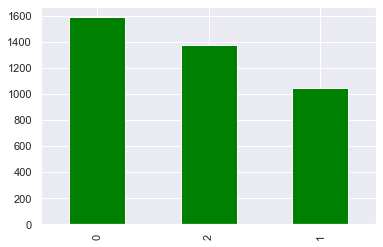

In [65]:
topics3_df.idxmax(axis=1).value_counts().plot.bar(color='green')

In [66]:
topics5_df.head()

,0,1,2,3,4
0,0.088747,0.097994,0.630653,0.072385,0.110222
1,0.042804,0.825166,0.041752,0.034775,0.055504
2,0.632803,0.098185,0.086519,0.072344,0.110149
3,0.042809,0.046909,0.822729,0.034753,0.052801
4,0.057568,0.381302,0.441407,0.046870,0.072854


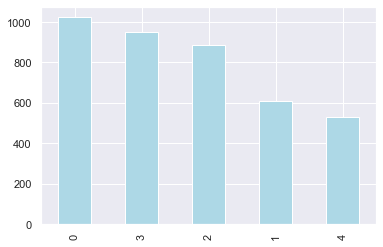

In [67]:
import seaborn as sns
sns.set(style="darkgrid", palette="viridis")
topics5_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

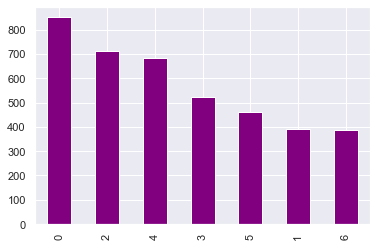

In [68]:
topics7_df.idxmax(axis=1).value_counts().plot.bar(color='purple')

# Visualizing the topics

In [69]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os

In [70]:
def generate_html_vis_file(model, num_topics, id2word, corpus):
    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_filepath = os.path.join('../data/ldavis_'+str(num_topics)+'_topics')
    
    # feed the LDA model into the pyLDAvis instance
    LDAvis_prepared = gensimvis.prepare(model, corpus, id2word)
    with open(LDAvis_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    with open(LDAvis_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, '../data/ldavis_'+ str(num_topics)+'_topics' +'.html')

In [71]:
generate_html_vis_file(lda_model3, 3, id2word, corpus)

In [72]:
generate_html_vis_file(lda_model5, 5, id2word, corpus)

In [73]:
generate_html_vis_file(lda_model7, 7, id2word, corpus)

Setting lambda = 1 results in the familiar ranking of terms in decreasing order of their topic-specific probability, 
and setting lambda = 0 ranks terms solely by their lift. We wish to learn an “optimal” value of lambda for topic interpretation.

See https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf page 4 to interpret lambda formula.

# Predicting new documents

In [74]:
new_q = "Which is your job role?"

We need to repeat the same cleaning steps as we did for the topic analysis.

In [75]:
def prepare_input(text):
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    tokens = simple_preprocess(text, deacc=True)
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    porter_stemmer=nltk.PorterStemmer()
    return [porter_stemmer.stem(word) for word in cleaned_tokens]

In [76]:
doc = prepare_input(new_q)
doc

['job', 'role']

In [77]:
lda_model5[id2word.doc2bow(doc)]

[(0, 0.057448067),
 (1, 0.06340653),
 (2, 0.05583961),
 (3, 0.751859),
 (4, 0.07144677)]

In [78]:
new_q2 = 'Sign up to become a paid customer and get an exclusive discount on your next purchase of $50 or more'

In [79]:
lda_model5[id2word.doc2bow(prepare_input(new_q2))]

[(0, 0.018627616),
 (1, 0.020531053),
 (2, 0.25082472),
 (3, 0.563172),
 (4, 0.1468446)]

In [80]:
lda_model3[id2word.doc2bow(prepare_input(new_q2))]

[(0, 0.4698416), (1, 0.043642953), (2, 0.48651543)]

In [81]:
lda_model7[id2word.doc2bow(prepare_input(new_q2))]

[(0, 0.014393203),
 (1, 0.016777858),
 (2, 0.012171949),
 (3, 0.015096987),
 (4, 0.3687963),
 (5, 0.55880004),
 (6, 0.013963635)]

## Conclusion

In order to choose the right number of topics for the modeling we need some domain knowledge. Based on the results we have analyzed so far, with 7 topics we start identifying more specific type of questions, though some overlapping also occurs. Besides the volume of 4000 is two small to consider the results relevants if the number of topics is too high.

By checking the top words of the topics, some potential **tags** could be:
1. Feedback from the user by rating some service (like, rate,...)
2. Sharing some contact request/social media info (twitter, website,...)
3. Requesting some phone/name/gender information or comments
4. Requesting some favourite food/music (dietary, personal info,...)

Increasing the number of topics gives us more detailed information about each topic but we would need more volumes of text in order to consider the probabilities relevant, since the percentage of documents covered by the topics decreases.